# PCLab#3 - Group 1 - Johannes, Petter, and Oskar

Big picture context
- You’ve just been hired by a sophisticated hedge-fund
- The hedge-fund manager is interested in Twitter’s predictive power
- He asks you to perform sentiment analysis on a sample of recent financial tweets...
- ... and to build a firm-level measure of media attention: that may be a great factor idea !

Packages you may need
- Among others: wordcloud, nltk.stem, nltk.corpus, nltk.tokenize, gensim, tensorflow, string.punctuation, sklearn, etc.

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

import re
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification


## Task #1: Basic manipulation and descriptive statistics
- Import the Data_PCLab3_Twitter_Stock_Sentiment.csv data and describe the sample (data available on BBoard)
- How many tweets, how many words per tweets, distribution of number of words per tweets, average sentiment, etc.

In [2]:
# load the data
twitter_df = pd.read_csv('./data/Data_PCLab3_Twitter_Stock_Sentiment.csv')
twitter_df.head(n=10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,0
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


In [3]:
twitter_df.describe()

,Sentiment
count,5791.000000
mean,0.636332
std,0.481096
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
twitter_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [5]:
# How many tweets?
print(f'How many tweets? There are {len(twitter_df)} tweets in the datasest')

# How many words per tweet?
words_per_tweet = twitter_df['Text'].apply(lambda x: len(x.split()))
print(f'How many words per tweet? There are {words_per_tweet.mean():.2f}')
print(f'Minimum words per tweet: {words_per_tweet.min():.0f}')
print(f'Maximum words per tweet: {words_per_tweet.max():.0f}')

How many tweets? There are 5791 tweets in the datasest
How many words per tweet? There are 14.01
Minimum words per tweet: 2
Maximum words per tweet: 32


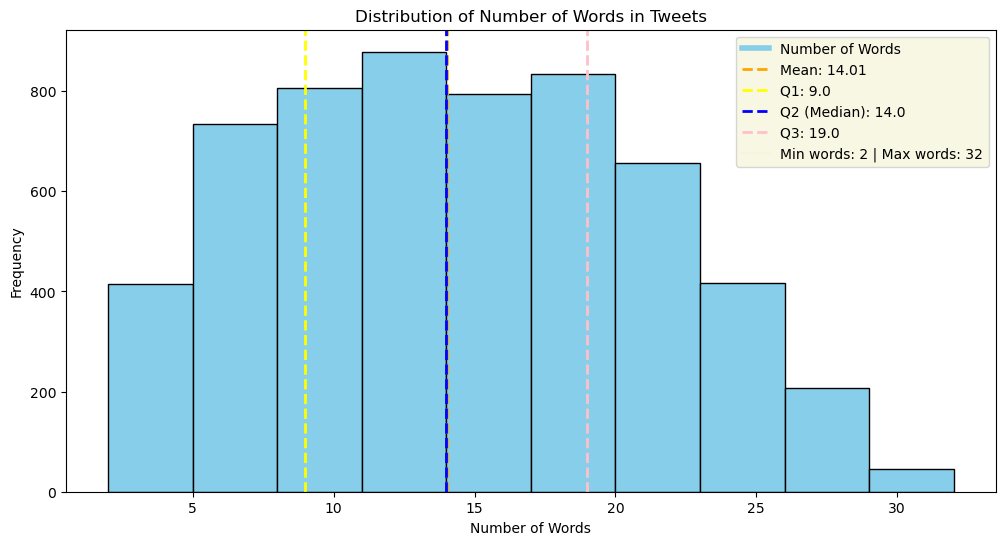

In [6]:
# Create a chart to show the distribution of number of words

# Calculate descriptive statistics
min_words = words_per_tweet.min()
max_words = words_per_tweet.max()
mean_words = words_per_tweet.mean()
quartiles = np.percentile(words_per_tweet, [25, 50, 75])

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(words_per_tweet, bins=10, color='skyblue', edgecolor='black')

# Add  lines for the descriptive statistics
plt.axvline(mean_words, color='orange', lw=2, linestyle='--', label='Mean')
plt.axvline(quartiles[0], color='yellow', lw=2, linestyle='--', label='Q1')
plt.axvline(quartiles[1], color='blue', lw=2, linestyle='--', label='Q2 (Median)')
plt.axvline(quartiles[2], color='pink', lw=2, linestyle='--', label='Q3')

# Add title and label axis
plt.title('Distribution of Number of Words in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Add a text box for annotations
# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], color='skyblue', lw=4, label='Number of Words'),
    plt.Line2D([0], [0], color='orange', linestyle='--', lw=2, label=f'Mean: {mean_words:.2f}'),
    plt.Line2D([0], [0], color='yellow', linestyle='--', lw=2, label=f'Q1: {quartiles[0]}'),
    plt.Line2D([0], [0], color='blue', linestyle='--', lw=2, label=f'Q2 (Median): {quartiles[1]}'),
    plt.Line2D([0], [0], color='pink', linestyle='--', lw=2, label=f'Q3: {quartiles[2]}'),
    plt.Line2D([0], [0], color='beige', label=f'Min words: {min_words} | Max words: {max_words}')
]

# Add the legend
plt.legend(facecolor='beige', handles=legend_elements, loc='best')

# Plot the chart
plt.show()

#### Describe the dataset
The dataset consists of 5791 tweets along with their corresponding sentiment values.

The dataset is structured with two columns:
- Text: This column contains the actual text content of each tweet.
- Sentiment: This column represents the sentiment associated with each tweet, with '1' indicating positive sentiment and '0' indicating negative sentiment.

##### Descriptive Statistics
- Average words per tweet: 14.01 words
- Average sentiment: 0.6363
- Minimum words per tweet: 2
- Maximum words per tweet: 32
- Distribution of words per tweet: Most tweets are between 5 and 23 tweets.Tweets rarely are longer than 25 words.

## Task #2 : Cleaning and visualization
- Usual cleaning steps: remove punctuation, stopwords, short words, etc.
- Try your cleaning on this sentence: $I love AI & Machine learning applied to Finance...!! ;)
- Plot a word cloud for text with positive and negative sentiment separately
- What is the number of unique words ?

In [7]:
# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
port_stem = PorterStemmer()

# Cleaning text data
def text_cleaning(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove special characters and numbers
    text = text.lower() # set all text to lowercase
    words = text.split() # tokenize the text
    words = [port_stem.stem(word) for word in words if word not in stop_words] # stem and remove stopwords
    return ' '.join(words)

# apply text cleaning to the text column of the data
twitter_df['clean_text'] = twitter_df['Text'].apply(text_cleaning)
    
# separate positive and negative tweets
positive_tweets = ' '.join(twitter_df[twitter_df['Sentiment'] == 1]['clean_text'])
negative_tweets = ' '.join(twitter_df[twitter_df['Sentiment'] == 0]['clean_text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PetterMoger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Cleaning this sentence: $I love AI & Machine learning applied to Finance...!! ;)
sentence = '$I love AI & Machine learning applied to Finance...!! ;)'

text_cleaning(sentence)

'love ai machin learn appli financ'

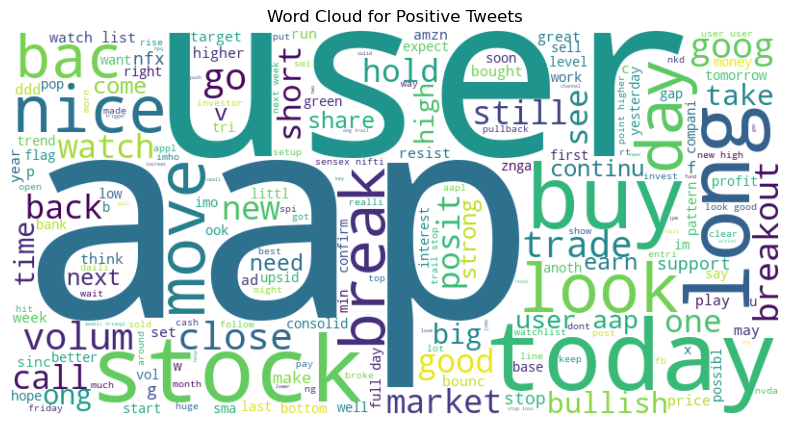

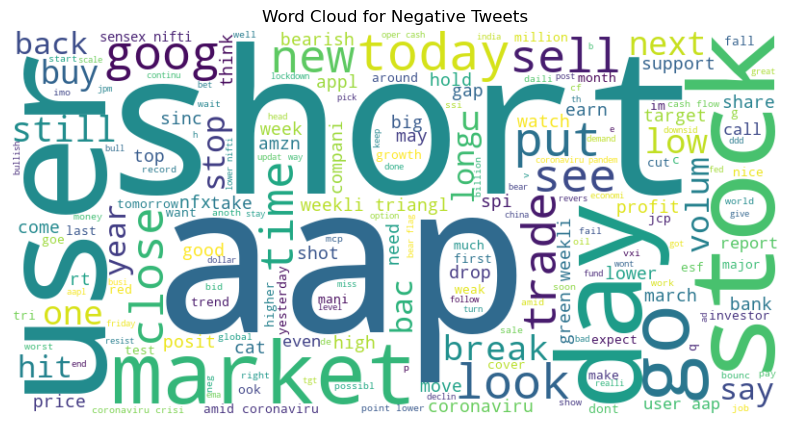

In [9]:
# create wordcloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
plot_wordcloud(positive_tweets, 'Word Cloud for Positive Tweets')
plot_wordcloud(negative_tweets, 'Word Cloud for Negative Tweets')

In [10]:
# what is the number of unique words? Answer: 9410

# function to count all occurances of each word in a list of sentences
def word_counter(list):
    word_map = {}
    for sentence in list:
        for word in sentence.split():
            if word in word_map:
                word_map[word] +=1
            else:
                word_map[word] = 1
    return word_map
    
clean_text_list = twitter_df['clean_text'].tolist()
word_map = word_counter(clean_text_list)
word_map = sorted(word_map.items(), key=lambda x:x[1], reverse=True) # sort word_map

print(f'Number of unique words: {len(word_map)}')

Number of unique words: 7511


**Comment on results:**
Not excluding tickers is a problem, as ticker such as AAP and GOOG are important words for both positive and negative sentiment tweets. This is likely a direct result of them both being big and liquid firms.

Furthermore, excluding numbers is not the best way to gain insight on sentiment. Consider this tweet: "AAPL target: 100". If the current price is 50, this is a positive sentiment, but if the price is 200, this is a negative sentiment. Thus, incorporating numbers may yield good results. However, this may lead to other problems due to the significant increase in complexity.

## Task #3 : Sentment analysis
If any of those steps are not crystal clear, please tell me now (or shoot me an email soon after the class)
- More usual steps: Tokenizing the text and padding
    - Tokenize: vectorize text corpus, transform text into numbers
    - Padding: make all sentences the same lenght (fill with 0 short sentences)
- Split the sample in a train / test dataset (test = 10% of the total sample)
- Train model of your choice (RNN, LTSM, etc.) to predict the sentiment (1 or 0) on the test sample (you could use embedding layer to reduce the dimension of the problem)
- Plot the confusion matrix and compute the accuracy score (e.g., with sklearn function accuracy)

**Tokenization and Padding**

In [11]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=len(word_map))  # Consider all the unique words
tokenizer.fit_on_texts(twitter_df['clean_text'])  # Fit on the cleaned text data

# convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(twitter_df['clean_text'])

# pad the sequences to ensure equal length
max_len = 32  # as there were at most 32 words in a single tweet
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

**Train-Test Split**

In [12]:
X = padded_sequences # the independent variables used to predict y
y = twitter_df['Sentiment'].values # the dependent variable

# split into 90% training and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1337)

**Train a model of our choice (LSTM)**

In [13]:
model = Sequential() # define a sequential model

model.add(Embedding(input_dim=len(word_map), output_dim=64)) # turns the input into a dense vector of fixed size

model.add(LSTM(units=64, return_sequences=False)) # add LSTM layer

model.add(Dropout(0.5)) # add dropout for regularization - at 0.5 probability, the network drops a unit

model.add(Dense(1, activation='sigmoid')) # add a dense layer for the output and use the sigmoid function to get probabilities

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile the model

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split = 0.1) # train the model

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6375 - loss: 0.6604 - val_accuracy: 0.6379 - val_loss: 0.6538
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7277 - loss: 0.5580 - val_accuracy: 0.6858 - val_loss: 0.5858
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8899 - loss: 0.3081 - val_accuracy: 0.7452 - val_loss: 0.5758
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9285 - loss: 0.2074 - val_accuracy: 0.7529 - val_loss: 0.7379
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9520 - loss: 0.1576 - val_accuracy: 0.7625 - val_loss: 0.7111


**Evaluate and Confusion-Matrix**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Accuracy: 0.76


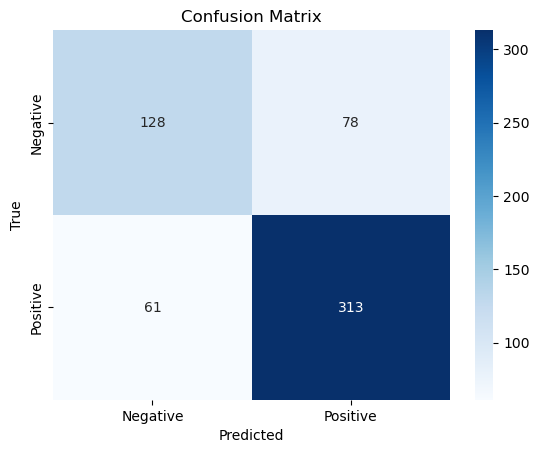

In [14]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten() # convert probabilities to binary

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Task #4 : Sentment analysis - Optional
- Use transformers (BERT from Huggingface) to perform another sentiment analysis and compare to the sentiment value in the data
    - Use pipeline: from transformers import pipeline
    - Use the already created library: text-classification or sentiment-analysis
- What is the performance of the algorithm on financial tweets ? I.e., how does BERT classifies the Tweets compared to the original classification you have ?
- Hint: check the Huggingface website
- To go further: check FinBERT

In [15]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=2, ignore_mismatched_sizes=True)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
labels = {0 : 'negative', 1 : 'positive'}
# labels = {0 : 'neutral', 1 : 'positive', 2 : 'negative'}

# run finbert tokenizer on twitter text
finbert_sent_val = list()

for tweet in twitter_df['Text']:
    inputs = tokenizer(tweet, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]
    
    sentiment = np.argmax(outputs.detach().numpy())
    finbert_sent_val.append(sentiment)

Accuracy: 0.3636677603177344


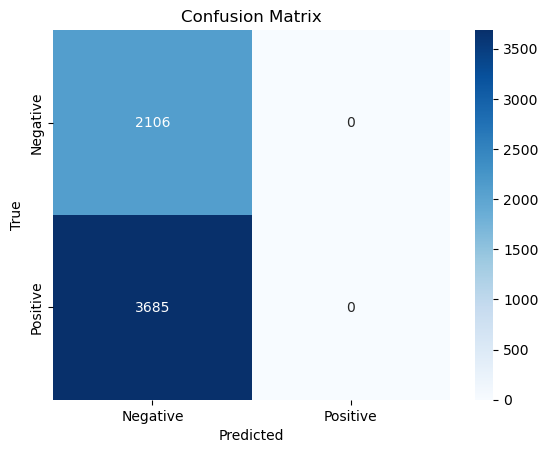

In [17]:
print(f'Accuracy: {accuracy_score(twitter_df["Sentiment"], finbert_sent_val)}')

# Plot confusion matrix
cm = confusion_matrix(twitter_df['Sentiment'], finbert_sent_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Results**
The finbert is poor at predicting, given the data we apply it to. For ~90% of the instances, finbert predicts negative sentiment.

## Task #5 : Measuring media attention
- Use the list of tickers gathered during last PC Lab (see the web-scrapping part) to compute the number of tweets about each stock
    - e.g., AAPL: 36 tweets, 12 negative, 24 positive
- Rank the stocks by their amount of total media attention, positive and negative media attention
- Optional: Using the stock prices data on our 8 stocks (or more from the web-scrapping task), do you see a correlation between media attention and excess return ?
- If yes, could Twitter attention is likely to be a good factor ?

**Collect Tickers**

In [18]:
# Load S&P 500 company list from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace '.' with '-' in symbols (needed for Yahoo Finance compatibility)
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Create a list of unique symbols
symbol_list = sp500['Symbol'].unique().tolist()

# Replace AAPL by AAP, as AAP is the ticker used for Apple in the twitter data
symbol_list = ['AAP' if ticker == 'AAPL' else ticker for ticker in symbol_list]

In [19]:
# initiate a dataframe with tickers as index and columns for mentions and positive sentiment tweets
ticker_df = pd.DataFrame(index=symbol_list, columns=['mentions', 'positive'])

# fill initial values as zero
ticker_df['mentions'] = 0
ticker_df['positive'] = 0


for i, row in twitter_df.iterrows():
    for ticker in symbol_list:
        if ticker in row['Text'].split():
            ticker_df.loc[ticker, 'mentions'] += 1

            if row['Sentiment'] == 1:
                ticker_df.loc[ticker, 'positive'] += 1

**Rank stocks after total media attention, positive mentions, and negative mentions**

In [20]:
ticker_df['negative'] = ticker_df['mentions'] - ticker_df['positive'] # create 'negative' column

ranked_mentions = ticker_df.sort_values('mentions', ascending=False) # Rank based on total media attention (mentions)

ranked_positive = ticker_df.sort_values('positive', ascending=False) # Rank based on positive mentions

ranked_negative = ticker_df.sort_values('negative', ascending=False) # Rank based on negative mentions

In [21]:
print('Top 5 Total Mentions:\n', ranked_mentions.head(5))
print('\nTop 5 Positive Mentions:\n', ranked_positive.head(5))
print('\nTop 5 Negative Mentions:\n', ranked_negative.head(5))

Top 5 Total Mentions:
       mentions  positive  negative
AAP        850       466       384
BAC        198       150        48
GOOG       184       114        70
AMZN        97        54        43
A           85        49        36

Top 5 Positive Mentions:
       mentions  positive  negative
AAP        850       466       384
BAC        198       150        48
GOOG       184       114        70
AMZN        97        54        43
A           85        49        36

Top 5 Negative Mentions:
       mentions  positive  negative
AAP        850       466       384
GOOG       184       114        70
BAC        198       150        48
AMZN        97        54        43
A           85        49        36


**Comment**
These results are not that interesting as we are more interested in the proporation of positive vs. negative mentions.

In [22]:
ticker_df['ratio'] = ticker_df.apply(lambda row: row['positive'] / row['negative'] if row['negative'] != 0 else row['positive'], axis=1)

print('Top 5 most positive ratio:\n', ticker_df.sort_values('ratio', ascending=False).head(5))

# filter only those with at least 3 mentions
print('\nTop 5 most negative ratio:\n', ticker_df[ticker_df['mentions'] >= 3].sort_values('ratio', ascending=True).head(5))

Top 5 most positive ratio:
       mentions  positive  negative      ratio
NVDA        35        32         3  10.666667
HD          10        10         0  10.000000
HES         11        10         1  10.000000
V           42        38         4   9.500000
F           31        28         3   9.333333

Top 5 most negative ratio:
       mentions  positive  negative     ratio
ICE          6         0         6  0.000000
WTW          4         0         4  0.000000
NEM         15         1        14  0.071429
ADBE         6         1         5  0.200000
CAT         44         9        35  0.257143


#### Does the difference in ratio say something about stock prices?
To test this, we'll create ten portfolios. The bins will be selected based on the ratio. Such, portfolio 1 will consist of the lowest ratioes, and portfolio 10 will consist of the highest ones. Once again, we filter out stocks with less than three mentions.

In [23]:
# C
ticker_df['portfolio'] = pd.qcut(ticker_df[ticker_df['mentions'] >= 3]['ratio'], 10,
                                 labels=[
                                     'Decile 1', 'Decile 2', 'Decile 3', 'Decile 4',
                                     'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8',
                                     'Decile 9', 'Decile 10'])

**Now that we have selected stocks based on ratio, we will see if they produce different risk adjusted returns (sharpe ratios)**

To do this, we first collect prices for the stocks over the previous 8 years.

In [24]:
# Define the date range (8 years before the end date)
end_date = '2023-12-31'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Download stock data
price_df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date).stack(future_stack=True)

# Clean up the index and column names
price_df.index.names = ['date', 'ticker']
price_df.columns = price_df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['SOLV', 'SW', 'GEV', 'AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 1451710800, endDate = 1703998800")


In [28]:
# Display the dataframe
prices_df = price_df.dropna(axis=0, how='any', inplace=True)
price_df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        37.941654   40.689999   41.189999   40.340000   41.060001   
           AAP     138.073349  152.240005  154.479996  147.509995  149.250000   
           ABBV     39.654152   57.610001   58.320000   56.400002   58.060001   
           ABT      36.403988   42.930000   44.049999   42.500000   43.939999   
           ACGL     22.950001   22.950001   23.219999   22.616667   22.940001   
...                       ...         ...         ...         ...         ...   
2023-12-29 XYL     113.428398  114.360001  114.680000  113.930000  114.089996   
           YUM     128.731308  130.660004  131.250000  130.210007  130.410004   
           ZBH     120.933403  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZTS     195.897507  197.369995  198.009995  196.250000  196.679993   

Price                  volume  
date       ticker              
2016-01-04 A        3287300.0  
           AAP      1935300.0  
           ABBV    10308400.0  
           ABT     12227500.0  
           ACGL     1220700.0  
...                       ...  
2023-12-29 XYL       698900.0  
           YUM      1196800.0  
           ZBH       849600.0  
           ZBRA      251300.0  
           ZTS      1007200.0  

[984053 rows x 6 columns]

Then, we calculate the annual returns and standard deviation for each year

adj close
date       ticker           
2016-01-04 AAP      0.026391
           ABBV    -0.007128
           ABT     -0.000820
           ACGL    -0.003696
           ACN      0.028581
...                      ...
2023-12-29 XYL      0.001636
           YUM      0.001349
           ZBH     -0.000606
           ZBRA     0.012602
           ZTS     -0.002833

[984052 rows x 1 columns]

In [65]:
returns_df['year'] = returns_df.index.get_level_values('date').year

annual_returns = returns_df.groupby(['year', 'ticker']).apply(lambda x: (1 + x).prod() - 1)
annual_returns

adj close          year
year ticker                          
2016 A        -0.221128  1.101362e+09
     AAP     494.455595  9.497417e+08
     ABBV     -0.828113  9.497417e+08
     ABT      -0.369624  9.497417e+08
     ACGL     -0.516232  9.497417e+08
...                 ...           ...
2023 XYL      -0.048204 -1.000000e+00
     YUM       0.872476 -1.000000e+00
     ZBH      -0.067818 -1.000000e+00
     ZBRA     18.116584 -1.000000e+00
     ZTS      -0.586804 -1.000000e+00

[3924 rows x 2 columns]